 Versuch 2
 ======
 
 Thema
 ------

Ziel dieses Versuchs ist es mit Hilfe von Clusteranalyse die Merkmale der aufgezeichneten Daten in unterschiedliche   
Rauhigkeitsklassen zu unterteilen. Die Fragestellung ist wie gut die Merkmale mit Clustering gelabelt werden können. Die zu analysierenden   
Daten wurde vorher mit einer Android App aufgenommen.   


 Versuchsaufbau
 ------
 
Die erfassten Daten sollen mit Clustering gelabelt werden. Dafür werden die zu betrachtenden Daten in Form einer bereits bearbeiteten CSV geladen.    
Durch Plots und Informationen der Daten soll analysiert werden, ob die gefunden Klassen sin ergeben. Zu weiteren Verarbeitung der Daten sollen      
die Merkmale um eine Spalte erweitert werden, um die zugeordneten Klassen abzuspeichern. Als Algorithmus wird KMeans verwendet mit der Implementierung von scikit-learn.  


In [4]:
# Bibliotheken laden
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipyleaflet import *
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn import preprocessing
from sklearn.externals import joblib
from scipy.interpolate import interp1d
import pandas

In [5]:
# Läd alle Messwerte
accXDf = pandas.read_csv("../daten/x-Achse-Beschleunigungswerte.csv")
accXDf.drop(['index'],axis=1 ,inplace=True)
accYDf = pandas.read_csv("../daten/y-Achse-Beschleunigungswerte.csv")
accYDf.drop(['index'],axis=1 ,inplace=True)
accZDf = pandas.read_csv("../daten/z-Achse-Beschleunigungswerte.csv")
accZDf.drop(['index'],axis=1 ,inplace=True)
pitchDf = pandas.read_csv("../daten/nick-Messwerte.csv")
pitchDf.drop(['index'],axis=1 ,inplace=True)
rollDf = pandas.read_csv("../daten/roll-Messwerte.csv")
rollDf.drop(['index'],axis=1 ,inplace=True)
azimuthDf = pandas.read_csv("../daten/azimuth-Messwerte.csv")
azimuthDf.drop(['index'],axis=1 ,inplace=True)
sensorTimestampsDf = pandas.read_csv("../daten/sensorevent-Zeitstempel.csv")
sensorTimestampsDf.drop(['index'],axis=1 ,inplace=True)

In [6]:
# Lesen der Merkmale
featuresDf = pandas.read_csv("../daten/merkmale.csv")
featuresDf.describe()

,Zeitstempel in Unixzeit,Breitengrad,Laengengrad,Geschwindigkeit in km/h,Anzahl der Messwerte,Start des Zeitfensters in ns seit Start der JVM,Start der Messwerterfassung in ns seit Start der JVM,Start der Belichtung in ns seit Start der JVM,Belichtungszeit in ns,Letzter Zeitstempel der Messwerterfassung in ns seit Start der JVM,...,Varianz X-Achse Beschleunigung in m/s^2,Varianz Y-Achse Beschleunigung in m/s^2,Varianz Z-Achse Beschleunigung in m/s^2,Varianz Nick in rad,Varianz Roll in rad,Standardabweichung X-Achse Beschleunigung in m/s^2,Standardabweichung Y-Achse Beschleunigung in m/s^2,Standardabweichung Z-Achse Beschleunigung in m/s^2,Standardabweichung Nick in rad,Standardabweichung Roll in rad
count,8.972000e+03,8972.000000,8972.000000,8972.000000,8972.000000,8.972000e+03,8.972000e+03,8.972000e+03,8.972000e+03,8.972000e+03,...,8972.000000,8972.000000,8972.000000,8972.000000,8972.000000,8972.000000,8972.000000,8972.000000,8972.000000,8972.000000
mean,1.523022e+12,53.617044,10.171727,13.979099,19.128399,4.276143e+13,4.276136e+13,4.276147e+13,3.481218e+06,4.276157e+13,...,4.092426,24.312174,28.904831,0.355811,0.488581,1.767940,4.044632,4.517134,0.535135,0.493986
std,9.279927e+05,0.003492,0.017890,3.855479,0.635943,9.279929e+11,9.279923e+11,9.279933e+11,2.714879e+06,9.279926e+11,...,6.301620,50.587132,47.056658,0.346376,1.150863,0.983322,2.820285,2.915696,0.263533,0.494557
min,1.523021e+12,53.613083,10.137841,5.004000,5.000000,4.115732e+13,4.115729e+13,4.115735e+13,6.435000e+05,4.115747e+13,...,0.015710,0.050650,0.032420,0.000320,0.000700,0.125340,0.225060,0.180060,0.017890,0.026460
25%,1.523021e+12,53.613976,10.156262,11.015999,19.000000,4.192303e+13,4.192296e+13,4.192307e+13,1.912116e+06,4.192318e+13,...,1.295162,5.523900,6.627232,0.109090,0.040695,1.138052,2.350298,2.574345,0.330290,0.201728
50%,1.523022e+12,53.615353,10.171855,14.112001,19.000000,4.283243e+13,4.283235e+13,4.283247e+13,2.298216e+06,4.283257e+13,...,2.398900,11.030570,13.847130,0.236775,0.094380,1.548840,3.321230,3.721175,0.486595,0.307210
75%,1.523023e+12,53.620280,10.186731,16.920000,19.000000,4.358764e+13,4.358756e+13,4.358768e+13,4.127597e+06,4.358778e+13,...,4.532242,23.149182,31.151130,0.491865,0.306120,2.128905,4.811360,5.581323,0.701327,0.553285
max,1.523024e+12,53.625160,10.201205,24.875998,43.000000,4.426992e+13,4.426987e+13,4.426995e+13,2.999632e+07,4.427009e+13,...,138.350270,927.527030,670.371910,2.600820,18.688130,11.762240,30.455330,25.891540,1.612710,4.322980


In [7]:
featuresDf.Breitengrad.shape[0]

8972

In [8]:
data = np.asarray([featuresDf['Geschwindigkeit in km/h'],featuresDf['Mittelwert X-Achse Beschleunigung in m/s^2'],featuresDf['Mittelwert Y-Achse Beschleunigung in m/s^2'],
                   featuresDf['Mittelwert X-Achse Beschleunigung in m/s^2']])

In [9]:
data = np.asarray([featuresDf['Geschwindigkeit in km/h'],featuresDf['Mittelwert X-Achse Beschleunigung in m/s^2'],featuresDf['Mittelwert Y-Achse Beschleunigung in m/s^2'],
                   featuresDf['Mittelwert Z-Achse Beschleunigung in m/s^2']])
data = data.T

In [10]:
data.shape

(8972, 4)

In [11]:
np.reshape(data.T[:,0],-1).shape

(4,)

In [179]:
%%time
y_pred = KMeans(n_clusters=3, max_iter=300, n_init=10).fit_predict(data)

Wall time: 107 ms


Text(0.5,0,'Geschwindigkeit in km/h')

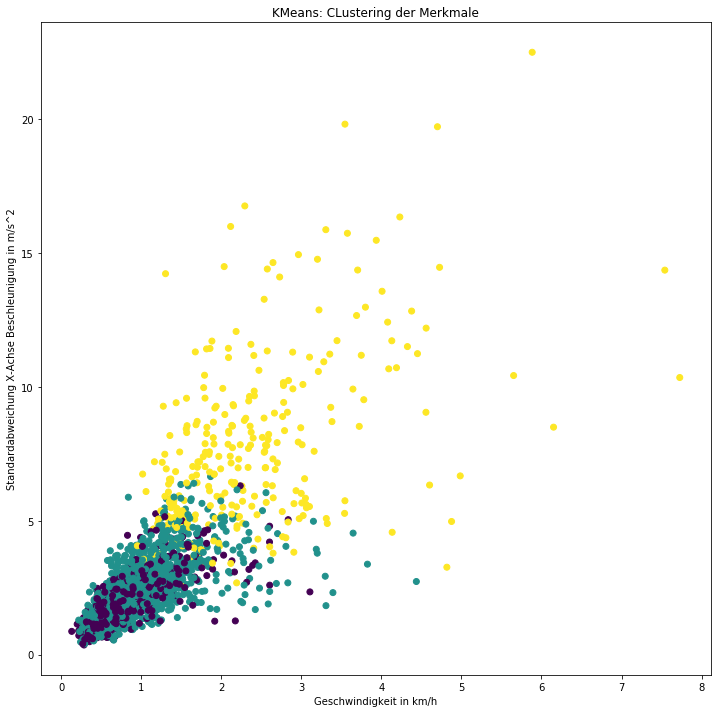

In [185]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(data[:,1],data[:,2],c=y_pred)
plt.title('KMeans: CLustering der Merkmale')
plt.ylabel('Standardabweichung X-Achse Beschleunigung in m/s^2')
plt.xlabel('Geschwindigkeit in km/h')

Text(0.5,0,'Geschwindigkeit in km/h')

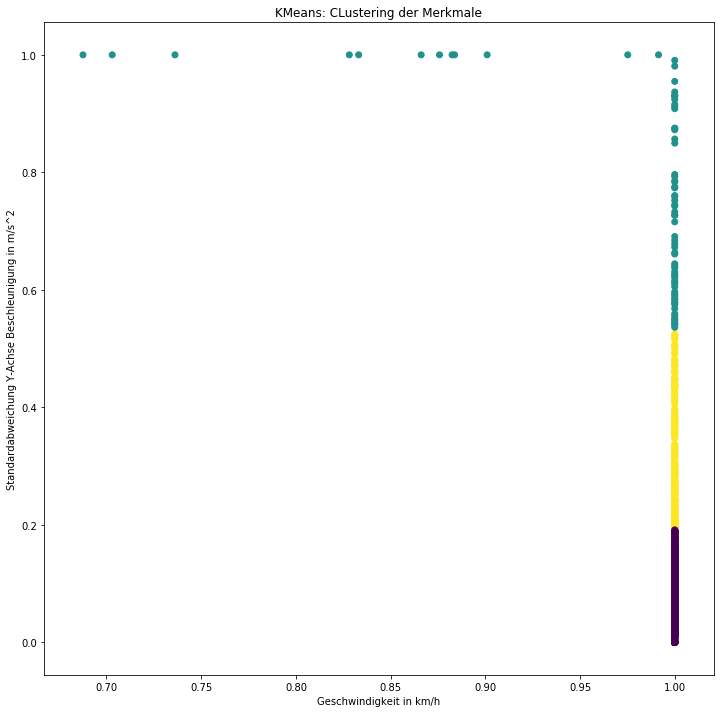

In [118]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(data[:,0],data[:,2],c=y_pred)
plt.title('KMeans: CLustering der Merkmale')
plt.ylabel('Standardabweichung Y-Achse Beschleunigung in m/s^2')
plt.xlabel('Geschwindigkeit in km/h')

NameError: name 'y_pred' is not defined

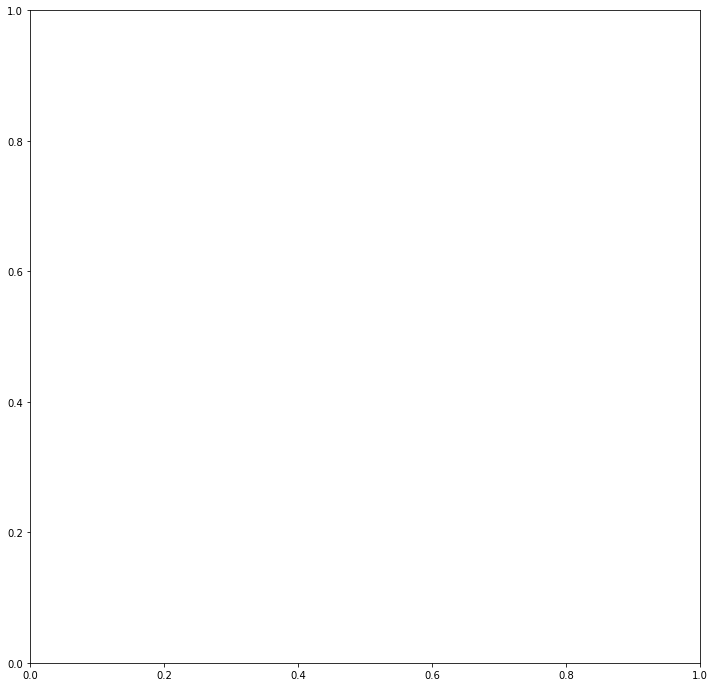

In [12]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(data[:,0],data[:,3],c=y_pred)
plt.title('KMeans: CLustering der Merkmale')
plt.ylabel('Standardabweichung Z-Achse Beschleunigung in m/s^2')
plt.xlabel('Geschwindigkeit in km/h')

In [8]:
y_pred[2000]

1

In [9]:
# Speichert Plot ab
fig.savefig('versuch2_KMeans')

In [10]:
# Speichert das Ergebnis des Modells ab
filename = "KMeans"
joblib.dump(y_pred, filename)

['KMeans']

In [39]:
# Läd Vorhersage
y_predLoad = joblib.load(filename)

In [27]:
# Lade Bilder in eine Liste
images = []
# Hier können die Datensätze ausgewählt werden
datasets = ['15','16','17']
# Die Pfade zu den Ordnern in welchem sich die Bilder befinden
paths = []
for dataset in datasets: # Für jeden Datensatz merke Pfad
    paths.append("C:/Users/JulianAdmin/Documents/daten/" + dataset + "/zugeschnitten/")
for path in paths: # Für jeden Pfad hole die Namen der Ordner
    folders = os.listdir(path)
    for folder in folders: # Aus der Liste der Ordner wird ein Ordner ausgewählt
        filesPath = path + folder + "/"
        print(filesPath)
        files = os.listdir(filesPath)
        for name in files: # Ein Dateiname aus diesem Ordner
            if "jpg" not in name:
                continue
            images.append(cv2.imread(filesPath + name)) # Bild wird gelesen

C:/Users/JulianAdmin/Documents/daten/15/zugeschnitten/1/
C:/Users/JulianAdmin/Documents/daten/15/zugeschnitten/2/
C:/Users/JulianAdmin/Documents/daten/15/zugeschnitten/3/
C:/Users/JulianAdmin/Documents/daten/15/zugeschnitten/4/
C:/Users/JulianAdmin/Documents/daten/15/zugeschnitten/5/
C:/Users/JulianAdmin/Documents/daten/15/zugeschnitten/6/
C:/Users/JulianAdmin/Documents/daten/15/zugeschnitten/7/
C:/Users/JulianAdmin/Documents/daten/15/zugeschnitten/8/
C:/Users/JulianAdmin/Documents/daten/16/zugeschnitten/1/
C:/Users/JulianAdmin/Documents/daten/16/zugeschnitten/2/
C:/Users/JulianAdmin/Documents/daten/16/zugeschnitten/3/
C:/Users/JulianAdmin/Documents/daten/16/zugeschnitten/4/
C:/Users/JulianAdmin/Documents/daten/16/zugeschnitten/5/
C:/Users/JulianAdmin/Documents/daten/16/zugeschnitten/6/
C:/Users/JulianAdmin/Documents/daten/16/zugeschnitten/7/
C:/Users/JulianAdmin/Documents/daten/16/zugeschnitten/8/
C:/Users/JulianAdmin/Documents/daten/17/zugeschnitten/1/
C:/Users/JulianAdmin/Documents/

In [29]:
# Index von welchem die Messwerte dargestellt werden sollen
row = 420
# Der erste und letzte Zeitstempel der Messwerterfassung
sensorTimestamps =  sensorTimestampsDf.iloc[row] / 1000000
timestampsMinMax = [sensorTimestampsDf.iloc[row,0]/ 1000000,sensorTimestampsDf.iloc[[row]].dropna(axis=1, how='any').iloc[0,-1]/ 1000000]
# Belichtungszeit vom Start bis zum Ende
startExposureTime = featuresDf['Start der Belichtung in ns seit Start der JVM'].iloc[row]-featuresDf['Start des Zeitfensters in ns seit Start der JVM'].iloc[row]
exposureTime = [startExposureTime/1000000,startExposureTime/1000000 + featuresDf['Belichtungszeit in ns'].iloc[row]/1000000]

<Figure size 720x720 with 0 Axes>

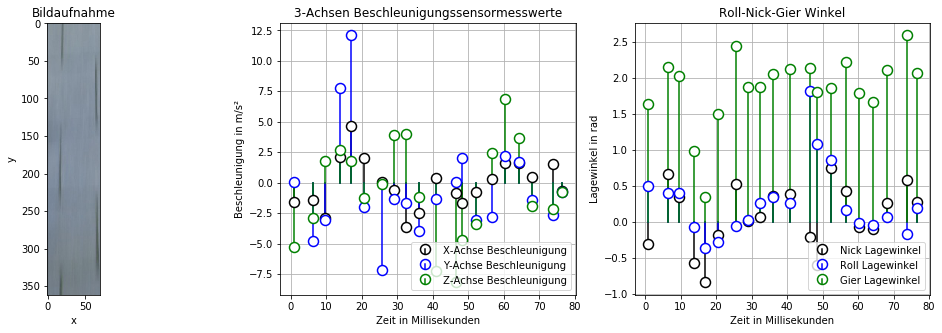

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[53.61389000000001, 10.146345], layers=(TileLayer(base=True, max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'tile_size']), Marker(location=[53.61389000000001, 10.146345], opacity=0.5, options=['alt', 'clickable', 'draggable', 'keyboard', 'rise_offset', 'rise_on_hover', 'title', 'z_index_offset'])), layout=Layout(height='300px', width='1000px'), options=['attribution_control', 'basemap', 'bounce_at_zoom_limits', 'box_zoom', 'center', 'close_popup_on_click', 'double_click_zoom', 'dragging', 'inertia', 'inertia_deceleration', 'inertia_max_speed', 'keyboard', 'keyboard_pan_offset', 'keyboard_zoom_offset', 'max_zoom', 'min_zoom', 'scroll_wheel_zoom', 'tap', 'tap_tolerance', 'touch_zoom', 'world_copy_jump', 'zoom', 'zoom_animation_threshold', 'zoom_control', 'zoom_start'], zoom=16)

In [30]:
# Mit Hilfe eines Subplots wird ein Bild mit einem Diagram der 3-Achsen Beschleunigungssensormesswerten und einem der Lagewinkel
# Roll-Nick-Gier dargestellt
plt.figure(0, figsize=(10,10))
f, axarr = plt.subplots(1, 3,figsize=(18,5))
axarr[0].imshow(cv2.cvtColor(images[row], cv2.COLOR_BGR2RGB))
axarr[0].set_title('Bildaufnahme')
axarr[0].set_xlabel('x')
axarr[0].set_ylabel('y')
# 3-Achsen Beschleunigungssensormesswerte
# X-Achse
(markers, stemlines, baseline) = axarr[1].stem(sensorTimestamps.dropna(), accXDf.iloc[row].dropna(), 'k-', basefmt='None', markerfmt='wo', label='X-Achse Beschleunigung')
plt.setp(stemlines, linestyle='-', color='k', linewidth=1.5)
plt.setp(markers, markeredgecolor='k', markersize=10, markeredgewidth=1.5, zorder=3)
# Y-Achse
(markers, stemlines, baseline) = axarr[1].stem(sensorTimestamps.dropna(), accYDf.iloc[row].dropna(), 'b-', basefmt='None', markerfmt='wo', label='Y-Achse Beschleunigung')
plt.setp(stemlines, linestyle='-', color='b', linewidth=1.5)
plt.setp(markers, markeredgecolor='b', markersize=10, markeredgewidth=1.5, zorder=3)
# Z-Achse
(markers, stemlines, baseline) = axarr[1].stem(sensorTimestamps.dropna(), accZDf.iloc[row].dropna(), 'g-', basefmt='None', markerfmt='wo', label='Z-Achse Beschleunigung')
plt.setp(stemlines, linestyle='-', color='g', linewidth=1.5)
plt.setp(markers, markeredgecolor='g', markersize=10, markeredgewidth=1.5, zorder=3)
axarr[1].set_title('3-Achsen Beschleunigungssensormesswerte')
axarr[1].set_xlabel('Zeit in Millisekunden')
axarr[1].set_ylabel('Beschleunigung in m/s²')
axarr[1].grid(True)
axarr[1].legend(loc='lower right', framealpha=0.8)
# Lagewinkel
(markers, stemlines, baseline) = axarr[2].stem(sensorTimestamps.dropna(), pitchDf.iloc[row].dropna(), 'k-', basefmt='None', markerfmt='wo', label='Nick Lagewinkel')
plt.setp(stemlines, linestyle='-', color='k', linewidth=1.5)
plt.setp(markers, markeredgecolor='k', markersize=10, markeredgewidth=1.5, zorder=3)
(markers, stemlines, baseline) = axarr[2].stem(sensorTimestamps.dropna(), rollDf.iloc[row].dropna(), 'b-', basefmt='None', markerfmt='wo', label='Roll Lagewinkel')
plt.setp(stemlines, linestyle="-", color='b', linewidth=1.5)
plt.setp(markers, markeredgecolor='b', markersize=10, markeredgewidth=1.5, zorder=3)
(markers, stemlines, baseline) = axarr[2].stem(sensorTimestamps.dropna(), azimuthDf.iloc[row].dropna(), 'g-', basefmt='None', markerfmt='wo', label='Gier Lagewinkel')
plt.setp(stemlines, linestyle="-", color='g', linewidth=1.5)
plt.setp(markers, markeredgecolor='g', markersize=10, markeredgewidth=1.5, zorder=3)
axarr[2].set_title('Roll-Nick-Gier Winkel')
axarr[2].set_xlabel('Zeit in Millisekunden')
axarr[2].set_ylabel('Lagewinkel in rad')
axarr[2].grid(True)
axarr[2].legend(loc='lower right', framealpha=0.8)
plt.show()
# Abstand der Subplots
f.subplots_adjust(hspace=0.5)
# ipyleaflet Karte
m = Map(center=(featuresDf.Breitengrad.iloc[row],featuresDf.Laengengrad.iloc[row]),zoom=16, layout=dict(width='1000px', height='300px'))
mark = Marker( location= m.center, opacity=0.5)
m += mark
m

In [18]:
featuresDf["Klasse"] =  y_pred

In [ ]:
featuresDf.set_index('Zeitstempel', inplace=True)
featuresDf.to_csv('../daten/merkmale.csv')

In [18]:
# Gibt die Anzahl der Merkmale mit der vorrausgesagten Klasse aus
classPred = 0
np.count_nonzero(y_pred == classPred)

11016